## Alignment methods
We will be using DTW to perform audio to score alignment. The matrix cost of the DTW will be computed using different features, later on we will compare which of these features is better for our current dataset.

In [92]:
#Needed imports
#you might to install these libraries:
%pip install pretty_midi
%pip install librosa
%pip install pyfluidsynth 
import sys
import numpy as np
import librosa, pretty_midi
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: C:\Users\ifc04\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: C:\Users\ifc04\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: C:\Users\ifc04\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [93]:
"""
This function aligns the chroma features of the score and the performance
and returns the alignment path as a numpy array of tuples (s,t) where s is the
time in the score and t is the time in the performance.
"""
def align_chroma(score_midi, perf, fs=44100, stride=512, n_fft=4096):
    score_synth = pretty_midi.PrettyMIDI(score_midi).synthesize(fs=fs)
    
    perf,_ = librosa.load(perf + '.wav', sr=fs)
    score_chroma = librosa.feature.chroma_stft(y=score_synth, sr=fs, tuning=0, norm=2,
                                               hop_length=stride, n_fft=n_fft)
    score_logch = librosa.power_to_db(score_chroma, ref=score_chroma.max())
    perf_chroma = librosa.feature.chroma_stft(y=perf, sr=fs, tuning=0, norm=2,
                                              hop_length=stride, n_fft=n_fft)
    perf_logch = librosa.power_to_db(perf_chroma, ref=perf_chroma.max())
    D, wp = librosa.sequence.dtw(X=score_logch, Y=perf_logch)
    path = np.array(list(reversed(np.asarray(wp))))

    return np.array([(s,t) for s,t in dict(reversed(wp)).items()])*(stride/fs)
"""
This function aligns the spectrogram features of the score and the performance
and returns the alignment path as a numpy array of tuples (s,t) where s is the
time in the score and t is the time in the performance.
"""
def align_spectra(score_midi, perf, fs=44100, stride=512, n_fft=4096):
    score_synth = pretty_midi.PrettyMIDI(score_midi).synthesize(fs=fs)

    perf,_ = librosa.load(perf + '.wav', sr=fs)
    score_spec = np.abs(librosa.stft(y=score_synth, hop_length=stride, n_fft=n_fft))**2
    score_logspec = librosa.power_to_db(score_spec, ref=score_spec.max())
    perf_spec = np.abs(librosa.stft(y=perf, hop_length=stride, n_fft=n_fft))**2
    perf_logspec = librosa.power_to_db(perf_spec, ref=perf_spec.max())
    D, wp = librosa.sequence.dtw(X=score_logspec, Y=perf_logspec)
    path = np.array(list(reversed(np.asarray(wp))))
    return np.array([(s,t) for s,t in dict(reversed(wp)).items()])*(stride/fs)

#sort of wrapper function
def align_all(score_midi, perf, fs=44100, stride=512, n_fft=4096):
    align1=align_chroma(score_midi, perf, fs, stride, n_fft)
    align2=align_spectra(score_midi, perf, fs, stride, n_fft)
    return align1,align2 #later on we'll save these alignments in a file


## Aligning each muiñeira with its corresponding performance

In [94]:
#Read data folder and print all its subfolders
data_dir = 'data'
list_muiñeiras = []
for root, dirs, files in os.walk(data_dir):
    for dir in dirs:
        #dir - name of the folder; path - path to the folder
        path=os.path.join(root,dir)
        if 'performance' not in path and   'score' not in path:
            list_muiñeiras.append(path)

#access the first muiñeira
"""
Gets the path to the muiñeira folder and aligns the score and performance
saves the alignment in a text file
"""
def align_muiñeira(muiñeira_path):
    try:
        os.mkdir(muiñeira_path+'/alignments')
        #access the score and performance of the first muiñeira
        score_path=muiñeira_path+'/score'
        perf_path=muiñeira_path+'/performance'
        #get wav file in performance folder
        perf_wav=[f for f in os.listdir(perf_path) if f.endswith('.wav')][0]
        #get midi file in score folder
        score_midi=[f for f in os.listdir(score_path) if f.endswith('.mid')][0]
        #align the score and performance
        align1,align2=align_all(score_path+'/'+score_midi, perf_path+'/'+perf_wav[:-4])
        #save first alignment in text file, row1 is time in score, row2 is time in performance
        #add a header to the file
        header='score_time, perf_time'
        #create new folder in muiñeira_path called 'alignments'
        #save the alignment in the new folder
        
        np.savetxt(muiñeira_path+'/alignments/align_chroma.txt', align1, delimiter=',', header=header)
        #save second alignment in text file, row1 is time in score, row2 is time in performance
        np.savetxt(muiñeira_path+'/alignments/align_spectra.txt', align2, delimiter=',', header=header)
    except:
        print('Folder already exists')


## Visualizing the results

We well create some helper functions to show the results of the alignment

In [95]:
def plot_alignment(align):
    #plot the alignment
    plt.figure(figsize=(15,5))
    plt.plot(align[:,0], align[:,1])
    plt.xlabel('Time in score')
    plt.ylabel('Time in performance')
    plt.show()

def plot_both_alignments(align1, align2):
    #plot the alignment
    plt.figure(figsize=(15,5))
    plt.plot(align1[:,0], align1[:,1], 'r')
    plt.plot(align2[:,0], align2[:,1], 'b')
    plt.xlabel('Time in score')
    plt.ylabel('Time in performance')
    plt.legend(['Chroma', 'Spectra'])
    plt.show()

#read the alignment from the text file
def read_alignment(file_path):
    return np.loadtxt(file_path, delimiter=',', skiprows=1)

In [96]:
#Example of use:
index=9
print(list_muiñeiras[index])
align_muiñeira(list_muiñeiras[index])


data\Muiñeira de Pol
Folder already exists


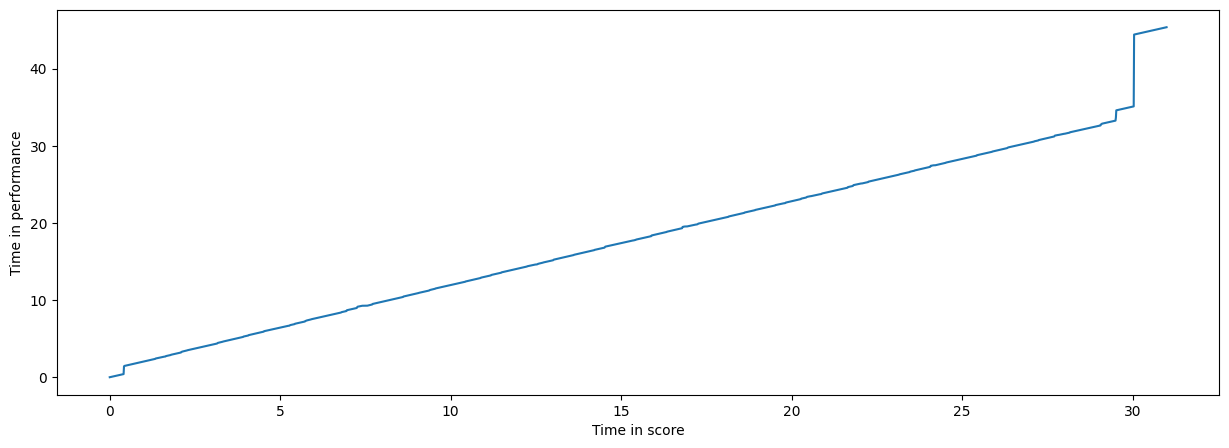

In [97]:
plot_alignment(read_alignment(list_muiñeiras[index]+'/alignments/align_chroma.txt'))

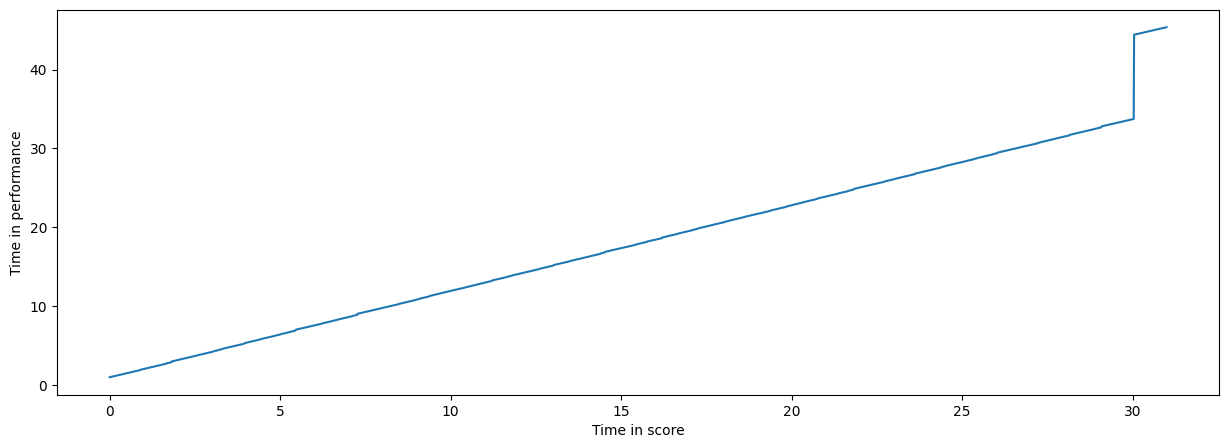

In [98]:
plot_alignment(read_alignment(list_muiñeiras[index]+'/alignments/align_spectra.txt'))

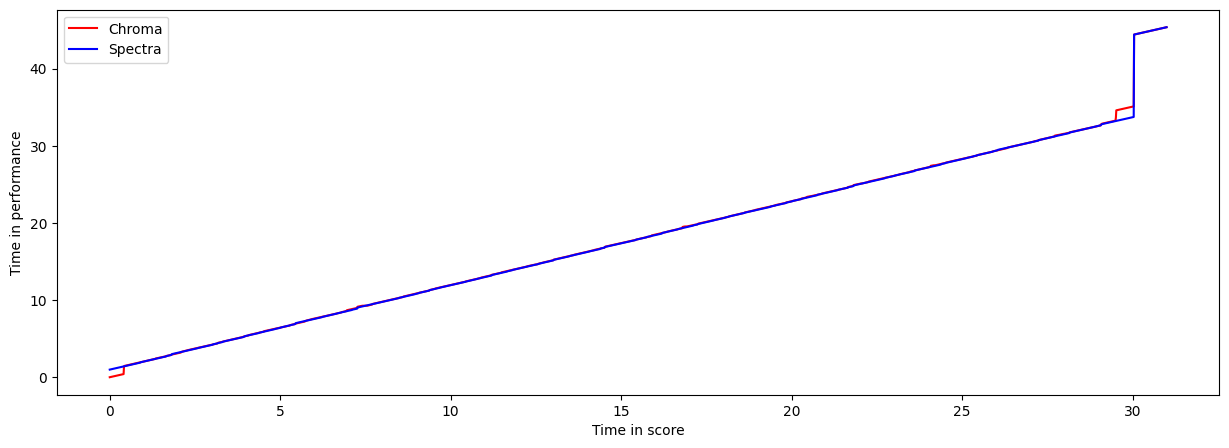

In [99]:
#plot both alignments
plot_both_alignments(read_alignment(list_muiñeiras[index]+'/alignments/align_chroma.txt'),
                        read_alignment(list_muiñeiras[index]+'/alignments/align_spectra.txt'))

Now let's align every track

In [102]:
for muiñeira in list_muiñeiras:
    align_muiñeira(muiñeira)


Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists


## Evaluating the alignment
We will evaluate the results in many different ways:

In [101]:
#dtw_distance
#pearson correlation
#the other stuff